### High Risk Pregnancy Prediction model using ML ALGORITHM


In [1]:
import os
import warnings
warnings.filterwarnings("ignore")


In [2]:
#!pip install pandas scikit-learn matplotlib seaborn xgboost


In [3]:
#Import libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import matplotlib.pyplot as plt
from xgboost import XGBClassifier





In [4]:
# Load Dataset
DATA_PATH = "/Users/akshata/Desktop/Project/HR Pregnancy/BaseDataset.csv"
df = pd.read_csv(DATA_PATH)



In [5]:
#Declaring Variables
df = df.dropna(subset=["Risk Level"]).copy()
target_col = "Risk Level"
feature_cols = [c for c in df.columns if c != target_col]
X = df[feature_cols].copy()
y = df[target_col].copy()



In [6]:
# Encode target labels
le = LabelEncoder()
y_enc = le.fit_transform(y.astype(str)) 
for i, label in enumerate(le.classes_):
    print(f"{i} is {label}")

0 is High
1 is Low


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])
preprocess = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features)],
    remainder="drop"
)



In [8]:
# Clinical rules
def clinical_rules_proba(df_part: pd.DataFrame):
    n = len(df_part)
    classes = list(le.classes_)
    proba = np.ones((n, len(classes)), dtype=float) / len(classes)
    idx_high = classes.index("High") if "High" in classes else None
    idx_low  = classes.index("Low")  if "Low"  in classes else None

    for i, row in df_part.iterrows():
        sbp = row.get("Systolic BP", np.nan)
        dbp = row.get("Diastolic", np.nan)
        bs  = row.get("BS", np.nan)
        temp= row.get("Body Temp", np.nan)
        bmi = row.get("BMI", np.nan)
        prev= row.get("Previous Complications", 0)
        preD= row.get("Preexisting Diabetes", 0)
        gdm = row.get("Gestational Diabetes", 0)
        mh  = row.get("Mental Health", 0)
        hr  = row.get("Heart Rate", np.nan)

        high_flags = 0
        moderate_flags = 0

        if pd.notna(sbp) and sbp >= 140: high_flags += 1
        if pd.notna(dbp) and dbp >= 90:  high_flags += 1
        if pd.notna(bs) and bs >= 7.8:   high_flags += 1
        if pd.notna(bmi) and bmi >= 35:  high_flags += 1
        if pd.notna(temp) and temp >= 100.4: high_flags += 1
        if pd.notna(hr) and (hr >= 110 or hr <= 50): high_flags += 1
        if preD == 1 or gdm == 1: high_flags += 1
        if prev == 1: high_flags += 1

        if pd.notna(sbp) and 130 <= sbp < 140: moderate_flags += 1
        if pd.notna(dbp) and 85  <= dbp < 90:  moderate_flags += 1
        if pd.notna(bs) and 6.7 <= bs < 7.8:   moderate_flags += 1
        if pd.notna(bmi) and 30  <= bmi < 35:  moderate_flags += 1
        if mh == 1: moderate_flags += 1

        base = np.ones(len(classes), dtype=float) / len(classes)
        if high_flags >= 1 and idx_high is not None:
            base *= 0.2
            base[idx_high] = 0.8
        elif moderate_flags >= 2 and idx_high is not None and idx_low is not None:
            base *= 0.2
            base[idx_high] = 0.6
            base[idx_low]  = 0.2
        elif idx_low is not None:
            base *= 0.2
            base[idx_low] = 0.8
        proba[i] = base

    return proba



In [13]:
# Models -> Logical Regression , RandomForestClassifier , XGBClassifier
log_reg = Pipeline(steps=[("prep", preprocess), ("clf", LogisticRegression(max_iter=400))])
rf_clf  = Pipeline(steps=[("prep", preprocess), ("clf", RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1))])
xgb_clf = Pipeline(steps=[("prep", preprocess), ("clf", XGBClassifier(n_estimators=500, max_depth=4, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9, random_state=42, n_jobs=-1, eval_metric="mlogloss"))])

estimators = [("lr", log_reg), ("rf", rf_clf), ("xgb", xgb_clf)]
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=400), stack_method="predict_proba", n_jobs=-1)
vote  = VotingClassifier(estimators=estimators, voting="soft", n_jobs=-1)

models = {
    "LogisticRegression": log_reg,
    "RandomForest": rf_clf,
    "XGBoost" : xgb_clf,
    "Stacking": stack,
    "SoftVoting": vote
}

results = []
pred_frames = []


LogisticRegression — Accuracy: 0.9706
              precision    recall  f1-score   support

        High       0.98      0.95      0.96        95
         Low       0.97      0.99      0.98       143

    accuracy                           0.97       238
   macro avg       0.97      0.97      0.97       238
weighted avg       0.97      0.97      0.97       238



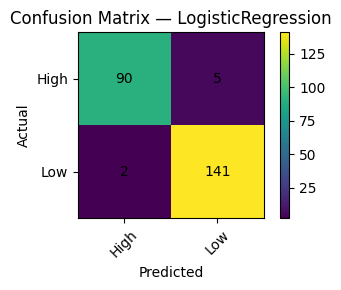


RandomForest — Accuracy: 0.9958
              precision    recall  f1-score   support

        High       1.00      0.99      0.99        95
         Low       0.99      1.00      1.00       143

    accuracy                           1.00       238
   macro avg       1.00      0.99      1.00       238
weighted avg       1.00      1.00      1.00       238



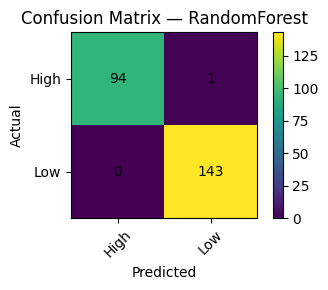


XGBoost — Accuracy: 0.9958
              precision    recall  f1-score   support

        High       1.00      0.99      0.99        95
         Low       0.99      1.00      1.00       143

    accuracy                           1.00       238
   macro avg       1.00      0.99      1.00       238
weighted avg       1.00      1.00      1.00       238



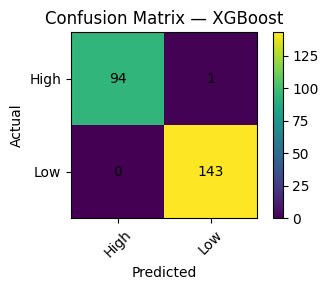


Stacking — Accuracy: 0.9958
              precision    recall  f1-score   support

        High       1.00      0.99      0.99        95
         Low       0.99      1.00      1.00       143

    accuracy                           1.00       238
   macro avg       1.00      0.99      1.00       238
weighted avg       1.00      1.00      1.00       238



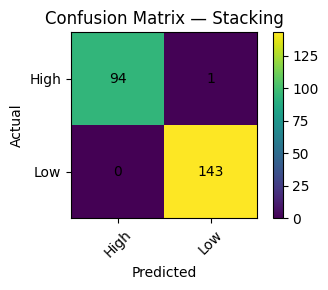


SoftVoting — Accuracy: 0.9916
              precision    recall  f1-score   support

        High       1.00      0.98      0.99        95
         Low       0.99      1.00      0.99       143

    accuracy                           0.99       238
   macro avg       0.99      0.99      0.99       238
weighted avg       0.99      0.99      0.99       238



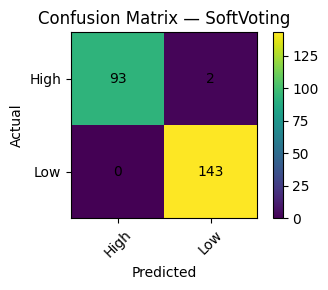

Model Accuracies (Clean Run)


,Model,Accuracy
1,RandomForest,0.995798
2,XGBoost,0.995798
3,Stacking,0.995798
4,SoftVoting,0.991597
0,LogisticRegression,0.970588


In [14]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({"Model": name, "Accuracy": acc})
    print(f"\n{name} — Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"Confusion Matrix — {name}")
    plt.colorbar()
    tick_marks = np.arange(len(le.classes_))
    plt.xticks(tick_marks, le.classes_, rotation=45)
    plt.yticks(tick_marks, le.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
    plt.tight_layout()
    plt.show()

    frame = pd.DataFrame({
        "y_true": le.inverse_transform(y_test),
        f"pred_{name}": le.inverse_transform(y_pred)
    }, index=np.arange(len(y_pred)))
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        if "High" in le.classes_:
            high_idx = list(le.classes_).index("High")
        else:
            high_idx = 0
        frame[f"proba_high_{name}"] = y_proba[:, high_idx]
    pred_frames.append(frame)

results_df = pd.DataFrame(results).sort_values("Accuracy", ascending=False)
print("Model Accuracies (Clean Run)")
results_df


Hybrid Combiner: alpha=0.3 with base model = RandomForest
Hybrid Accuracy: 0.9832
              precision    recall  f1-score   support

        High       0.96      1.00      0.98        95
         Low       1.00      0.97      0.99       143

    accuracy                           0.98       238
   macro avg       0.98      0.99      0.98       238
weighted avg       0.98      0.98      0.98       238



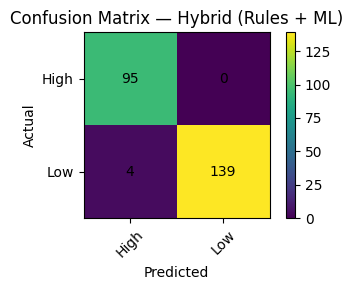

In [15]:
# Hybrid
rules_proba_test = clinical_rules_proba(X_test.reset_index(drop=True))
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]
ml_proba = best_model.predict_proba(X_test)
alpha = 0.30 
hybrid_proba = alpha * rules_proba_test + (1 - alpha) * ml_proba
hybrid_pred = hybrid_proba.argmax(axis=1)

print(f"\nHybrid Combiner: alpha={alpha} with base model = {best_model_name}")
hyb_acc = accuracy_score(y_test, hybrid_pred)
print(f"Hybrid Accuracy: {hyb_acc:.4f}")
print(classification_report(y_test, hybrid_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, hybrid_pred)
plt.figure(figsize=(4, 3))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix — Hybrid (Rules + ML)")
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45)
plt.yticks(tick_marks, le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
plt.tight_layout()
plt.show()


In [16]:
# Collect predictions
preds_merged = pred_frames[0]
for fr in pred_frames[1:]:
    preds_merged = preds_merged.join(fr.drop(columns=["y_true"]), how="left")
preds_merged["pred_Hybrid"] = le.inverse_transform(hybrid_pred)
if "High" in le.classes_:
    high_idx = list(le.classes_).index("High")
else:
    high_idx = 0
preds_merged["proba_high_Hybrid"] = hybrid_proba[:, high_idx]



Top permutation importances:
 Gestational Diabetes      0.076050
Preexisting Diabetes      0.065126
BMI                       0.039916
BS                        0.029412
Heart Rate                0.014706
Mental Health             0.012185
Previous Complications    0.010924
Systolic BP               0.001261
Age                       0.000000
Body Temp                 0.000000
Diastolic                -0.001261
dtype: float64


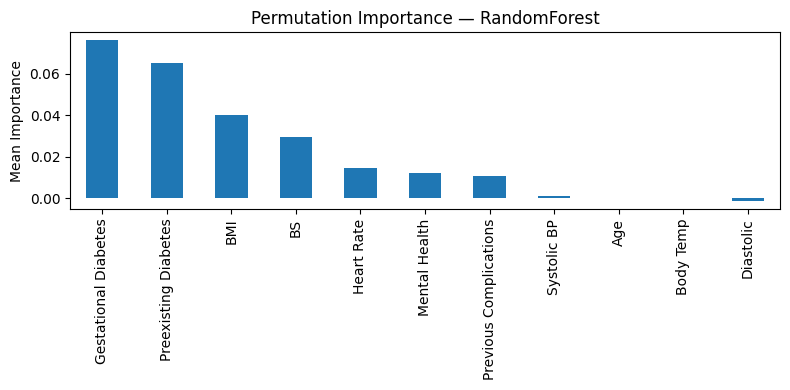

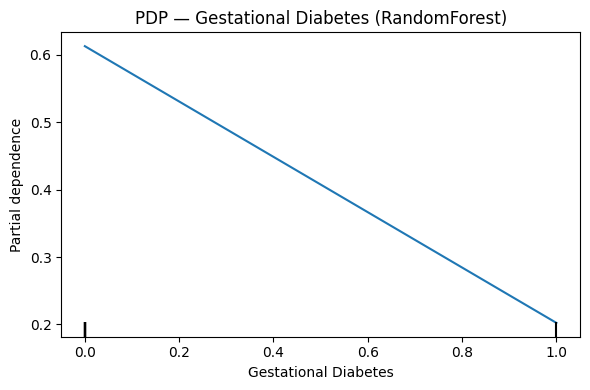

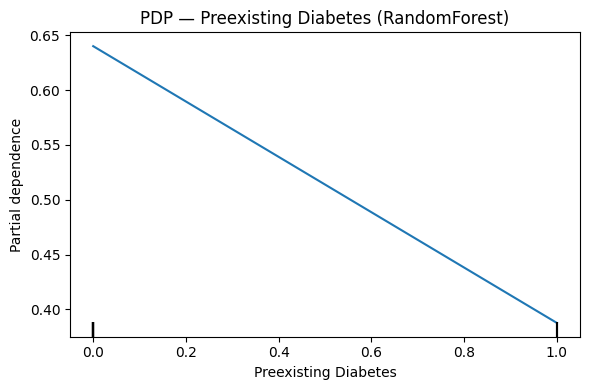

In [17]:
# XAI: Permutation Importance + PDP on best model
# --- Permutation Importance ---
r = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=10, random_state=42, scoring="accuracy"
)

# Features from XTEST
imp = pd.Series(r.importances_mean, index=X_test.columns).sort_values(ascending=False)

print("\nTop permutation importances:\n", imp.head(12))

# Plot top features
plt.figure(figsize=(8, 4))
imp.head(12).plot(kind="bar")
plt.title(f"Permutation Importance — {best_model_name}")
plt.ylabel("Mean Importance")
plt.tight_layout()
plt.show()

# --- Partial Dependence Plots (PDP) ---
top_features = imp.head(5).index.tolist()   # take more than 2 in case some fail

plotted = 0
for feat in top_features:
    try:
        fig, ax = plt.subplots(figsize=(6, 4))
        PartialDependenceDisplay.from_estimator(best_model, X_test, features=[feat], ax=ax)
        plt.title(f"PDP — {feat} ({best_model_name})")
        plt.tight_layout()
        plt.show()
        plotted += 1
        if plotted == 2:   # only show 2 valid PDPs
            break
    except Exception as e:
        print(f"Skipping feature {feat} (not suitable for PDP): {e}")
